In [1]:
import pandas as pd
import torch
from PIL import Image
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from torchvision import transforms
import re
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
warnings.filterwarnings("ignore", category=UserWarning)  # Disable UserWarnings
tqdm.pandas()

In [2]:
train_df = pd.read_csv("./dataset/train.csv")
test_df = pd.read_csv("./dataset/test.csv")
validation_df = pd.read_csv("./dataset/val.csv")

In [3]:
train_df

,id,caption,image_id,label
0,417812c5-0ce4-499d-b97d-4d28827239bc,Wet elephants shake water onto people bathing ...,394330,0
1,5ac91fa3-55f2-4cb3-8c8f-ad84f78e6b36,Two men holding tennis racquets on the court,130849,0
2,d2705b90-8347-4cab-a7a6-654540d9a489,A bird on a tree limb with mountains in the ba...,514790,0
3,a3b33fe7-3085-4433-9c18-8814803891b4,A kitchen and dining room are featured along w...,182096,0
4,1514b0e4-0665-45bc-ab32-52fce326cc29,A fruit stand has various fruits on the table.,68788,1
...,...,...,...,...
9995,1d1df243-485d-4b29-82c8-7e34c0de1f5c,Several people stand in a field flying a kite.,522702,0
9996,f7dfa883-e524-4974-b5ba-6b3c3db49087,A batter hitting a pitch at a baseball game.,441874,1
9997,602e83dc-6539-4c1a-8d19-c1481b5c24bf,A person on white surfboard next to group in a...,166716,0
9998,d9ce2e8c-0831-466a-8756-4c40d772b1ce,A baseball player getting ready to swing at th...,517601,0


In [4]:

# Compile the regular expression pattern
pattern = re.compile(r"[^a-z ]")


def text_preparetion(sentence):
    # 1. Lowercase everything
    sentence = sentence.lower()

    # 2. Remove all symbols other than a-z.
    sentence = re.sub(pattern, " ", sentence)

    return sentence

sentence1 = "A World War II-era bomber flying out of formation"
text_preparetion(sentence1)

'a world war ii era bomber flying out of formation'

In [5]:
train_df['preprocessed_text'] = train_df['caption'].progress_apply(text_preparetion)
validation_df['preprocessed_text'] = validation_df['caption'].progress_apply(text_preparetion)
test_df['preprocessed_text'] = test_df['caption'].progress_apply(text_preparetion)

100%|██████████| 2000/2000 [00:00<00:00, 570537.17it/s]


In [6]:
from collections import defaultdict


def build_simple_vocab(sentences, special_tokens=None):
    """
    Manually create a vocabulary from a list of tokenized sentences.
    
    Args:
        sentences (list of str): List of sentences to build vocabulary from.
        special_tokens (list of str): Special tokens like <pad>, <unk>.
        
    Returns:
        dict: A vocabulary mapping tokens to indices.
        dict: An inverse vocabulary mapping indices to tokens.
    """
    special_tokens = special_tokens or ['<pad>', '<unk>']
    vocab = defaultdict(lambda: len(vocab))  # Default index is the current vocab size
    for token in special_tokens:
        vocab[token]  # Add special tokens first
    
    # Add tokens from sentences
    for sentence in sentences:
        for token in sentence.split():
            if token.strip():  # Exclude empty tokens
                vocab[token]
    
    # Convert to a normal dict (no longer dynamic)
    vocab = dict(vocab)
    inverse_vocab = {index: token for token, index in vocab.items()}
    return vocab, inverse_vocab


# Vectorize a sentence
def vectorize_sentence(sentence, vocab):
    """
    Converts a sentence into a tensor of token indices using a given vocabulary,
    ignoring empty tokens.
    
    Args:
        sentence (str): Input sentence.
        vocab (Vocab): Vocabulary to map tokens to indices.
        
    Returns:
        torch.Tensor: Vectorized sentence as a tensor.
    """
    # Ensure '<unk>' exists in the vocabulary
    unk_idx = vocab.get('<unk>', -1)
    if unk_idx == -1:
        raise ValueError("The vocabulary must include '<unk>' for unknown tokens.")

    # Split sentence into tokens and map them to indices
    tokens = [token for token in sentence.split() if token.strip()]
    return torch.tensor([vocab.get(token, unk_idx) for token in tokens], dtype=torch.long)


# Custom Dataset Class
class PreprocessingDataset(Dataset):
    def __init__(self, dataframe, vocab, images_path, train=True, max_len=None):
        """
        Dataset for preprocessing image-text pairs.

        Args:
            dataframe (pd.DataFrame): DataFrame containing 'image_id', 'sentence', and optionally 'label'.
            vocab (Vocab): Vocabulary for text vectorization.
            train (bool): Whether this is a training dataset.
            max_len (int): Maximum length for sentences. If None, no truncation.
        """
        super().__init__()
        self.dataframe = dataframe
        self.vocab = vocab
        self.train = train
        self.max_len = max_len
        self.images_path = images_path

        # Define image transformations
        self.image_transform = transforms.Compose([
            # transforms.RandomResizedCrop(100, scale=(0.8, 1.0)),
            # transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Process sentence
        sentence = row['caption']
        vectorized_sentence = vectorize_sentence(sentence, self.vocab)

        # Pad or truncate the sentence
        if len(vectorized_sentence) < self.max_len:
            padding_length = self.max_len - len(vectorized_sentence)
            pad_tensor = torch.full((padding_length,), self.vocab['<pad>'], dtype=torch.long)
            vectorized_sentence = torch.cat((vectorized_sentence, pad_tensor), dim=0)
        else:
            vectorized_sentence = vectorized_sentence[:self.max_len]

        # Process image
        image_path = f"{self.images_path}{row['image_id']}.jpg"
            
        try:
            image = Image.open(image_path).convert("RGB")  # Convert to RGB
            image = self.image_transform(image)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image not found at path: {image_path}")

        # Handle labels (for training)
        if self.train:
            label = row['label']
            label = torch.tensor(label, dtype=torch.long)
            return {
                'images': image,
                'captions': vectorized_sentence,
                'labels': label
            }
        else:
            return {
                'images': image,
                'captions': vectorized_sentence,
                'id': row['id']
            }


In [7]:
tokenized_sentence = [sentence.split(" ") for sentence in train_df['preprocessed_text']]
max_len = max(len([token.strip() for token in sentence.split(" ")]) for sentence in train_df['preprocessed_text'])
vocab, inverse_vocab = build_simple_vocab(train_df['preprocessed_text'])

In [8]:
train_dataset = PreprocessingDataset(train_df, vocab, train=True, max_len=max_len, images_path = "./dataset/train_images/")
test_dataset = PreprocessingDataset(test_df, vocab, train=False, max_len=max_len, images_path = "./dataset/test_images/")
val_dataset = PreprocessingDataset(validation_df, vocab, train=True, max_len=max_len, images_path = "./dataset/val_images/")

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True )
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
class TextModule(nn.Module):
    def __init__(self, vocab_size, embedding_dim, lstm_hidden_dim, lstm_dropout):
        super(TextModule, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=vocab["<pad>"])
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=lstm_hidden_dim, batch_first=True,
                            dropout=lstm_dropout,  # Dropout between LSTM layers
                            bidirectional=False)   # Unidirectional LSTM
        
        # Regularization for LSTM (weight clipping)
        self.lstm_clipping = 1.0  # Clipping threshold for gradient values

    def forward(self, captions):
        # Text feature extraction
        embedded_captions = self.embedding(captions)  # Shape: (batch_size, seq_len, embedding_dim)
    
        lstm_out, (lstm_hidden, _) = self.lstm(embedded_captions)  # lstm_hidden: (1, Batch, HiddenDim)
        text_features = lstm_hidden.squeeze(0)  # (Batch, HiddenDim)
    
        return text_features

    
    def clip_lstm_weights(self):
        # Clip LSTM weights to prevent exploding gradients
        for name, param in self.lstm.named_parameters():
            if "weight" in name:
                param.data = torch.clamp(param.data, -self.lstm_clipping, self.lstm_clipping)

In [12]:
class Head(nn.Module):
    def __init__(self, image_feature_dim, text_feature_dim, head_dropout_value, num_classes):
        super(Head, self).__init__()
        self.fc1 = nn.Linear(image_feature_dim + text_feature_dim, 128)  # Combine image + text features
        self.dropout_fc = nn.Dropout(head_dropout_value)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, img_features, text_features):
        # Combine image and text features
        combined_features = torch.cat((img_features, text_features), dim=1)  # (Batch, 128 + HiddenDim)
        
        # Classification
        x = F.relu(self.fc1(combined_features))  # (Batch, 256)
        x = self.dropout_fc(x)  # Apply dropout
        x = self.fc2(x)  # (Batch, 1 for binary classification)
        return x.squeeze(1)  # Logits (not probabilities)

In [13]:
class CNN(nn.Module):
    def __init__(self, cnn_dropout):
        super(CNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),  # (Batch, 16, H, W)
            nn.ReLU(),
            nn.BatchNorm2d(16),  # Normalize
            nn.Dropout(cnn_dropout),     # Dropout
            nn.MaxPool2d(kernel_size=2, stride=2),  # (Batch, 32, H/2, W/2)
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),  # (Batch, 32, H/2, W/2)
            nn.ReLU(),
            nn.BatchNorm2d(32),  # Normalize
            nn.Dropout(cnn_dropout),     # Dropout
            nn.MaxPool2d(kernel_size=2, stride=2),  # (Batch, 64, H/4, W/4)
            
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),  # (Batch, 32, H/4, W/4)
            nn.ReLU(),
            nn.BatchNorm2d(32),  # Normalize
            nn.Dropout(cnn_dropout),      # Dropout
            nn.AdaptiveAvgPool2d((2, 2))  # Output size (Batch, 128, 1, 1)
        )
        self.flatten = nn.Flatten()

    def forward(self, images):
        img_features = self.layers(images)  # (Batch, 64, 1, 1)
        img_features = self.flatten(img_features)  # (Batch, 64)
        return img_features

In [14]:
class ImageTextClassifier(nn.Module):
    def __init__(self, vocab_size, cnn_dropout, embedding_dim, lstm_hidden_dim, lstm_dropout, head_dropout_value):
        super(ImageTextClassifier, self).__init__()
        self.cnn = CNN(cnn_dropout)
        self.text_module = TextModule(vocab_size, embedding_dim, lstm_hidden_dim, lstm_dropout)
        self.head = Head(image_feature_dim=32 * 4, text_feature_dim=64, head_dropout_value=head_dropout_value, num_classes=1)

    def forward(self, images, captions):
        img_features = self.cnn(images)  # Image feature extraction
        text_features = self.text_module(captions)  # Text feature extraction
        return self.head(img_features, text_features)  # Classification

In [15]:
import torch.nn as nn

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Embedding):
        nn.init.xavier_uniform_(m.weight)
    elif isinstance(m, nn.BatchNorm2d):  # Initialize BatchNorm layers
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LayerNorm):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.TransformerEncoderLayer):
        for name, param in m.named_parameters():
            if "weight" in name:
                if param.dim() > 1:
                    nn.init.xavier_uniform_(param)
                else:
                    nn.init.ones_(param)
            elif "bias" in name:
                nn.init.zeros_(param)

In [20]:
model_config = {
    "vocab_size" : len(vocab),   # Total number of words in vocabulary
    "embedding_dim": 64,       # Dimension of word embeddings
    "cnn_dropout": 0.25, 
    "lstm_hidden_dim": 64,     # Hidden state size for LSTM
    "lstm_dropout": 0.5,
    "head_dropout_value": 0.25
}

# Initialize the model
model = ImageTextClassifier(**model_config)
model.to(device)
# model.apply(initialize_weights)

# Dummy input data
# images = torch.randn(16, 3, 100, 100).to(device)  # Batch of 16 RGB images of size 224x224
# captions = torch.randint(0, len(vocab), (16, max_len)).to(device)  # Batch of 16 captions with max_len tokens each
# 
# output = model(images, captions)
# print(output.shape)  # Should be (16) 

ImageTextClassifier(
  (cnn): CNN(
    (layers): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.25, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU()
      (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Dropout(p=0.25, inplace=False)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU()
      (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): Dropout(p=0.25, inplace=False)
      (14): AdaptiveAvgPool2d(output_size=(2, 2))
    )
    (flatten): Flatten(s

In [21]:
cnn_params = model.cnn.parameters()  # Parameters of the CNN module
text_params = model.text_module.parameters()  # Parameters of the text module
head_params = model.head.parameters()

cnn_optimizer = optim.AdamW(cnn_params, lr=1e-3, weight_decay=1e-3)
text_optimizer = optim.AdamW(text_params, lr=1e-4, weight_decay=1e-3)
head_optimizer = optim.AdamW(head_params, lr=5e-4, weight_decay=1e-3)

cnn_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    cnn_optimizer, 
    T_0=10,  # Number of epochs before the first restart
    T_mult=1,  # Multiplicative factor for increasing restart period
    eta_min=1e-5  # Minimum learning rate
)

text_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    text_optimizer,
    T_0=10,  # Number of epochs before the first restart
    T_mult=1,  # Multiplicative factor for increasing restart period
    eta_min=1e-5  # Minimum learning rate
)

head_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    head_optimizer,
    T_0=10,  # Number of epochs before the first restart
    T_mult=1,  # Multiplicative factor for increasing restart period
    eta_min=1e-5  # Minimum learning rate
)

criterion = nn.BCEWithLogitsLoss()  # Use logits directly

In [22]:
import copy

def training_method(model, criterion, cnn_optimizer, text_optimizer, head_optimizer, cnn_scheduler, text_scheduler, head_scheduler, num_epochs, train_loader, val_loader, patience=5, delta = 0.2, loss_procentage_improvement=10, pred_thresh=0.5):
    train_losses = []  # List to store training losses
    val_losses = []  # List to store validation losses
    val_accuracies = []  # List to store validation accuracies
    val_precisions = []  # List to store validation precisions
    val_recalls = []  # List to store validation recalls
    val_f1s = []  # List to store validation F1-scores
    learning_rates = [] # List to store learning rate progression

    best_val_loss = float('inf')  # Initialize the best validation loss
    initial_loss = float('inf')
    best_model = None  # Store the best model
    epochs_without_improvement = 0  # Track epochs without improvement

    for epoch in range(num_epochs):
        start_time = time.time()
        ### TRAINING
        model.train()
        training_loss = 0.0
        
        for batch in train_loader:
            images = batch['images'].to(device)      # Images from batch
            captions = batch['captions'].to(device)  # Captions from batch
            labels = batch['labels'].to(device).float()  # Binary labels (0/1), converted to float
            
            cnn_optimizer.zero_grad()  # Reset gradients
            text_optimizer.zero_grad()
            head_optimizer.zero_grad()
            
            output = model(images, captions)  # Forward pass (logits)
            loss = criterion(output, labels)  # Compute loss
            loss.backward()  # Backpropagation
            
            # model.text_module.clip_lstm_weights()
            
            cnn_optimizer.step()  # Update weights
            text_optimizer.step()
            head_optimizer.step()
            
            training_loss += loss.item()  # Accumulate loss
            
        train_loss = training_loss / len(train_loader)  # Average training loss
        train_losses.append(train_loss)

        ### VALIDATING
        model.eval()
        validation_loss = 0.0
        all_labels = []  # Ground truth labels for validation
        all_preds = []   # Predictions for validation
        
        with torch.no_grad():
            for batch in val_loader:
                images = batch['images'].to(device)
                captions = batch['captions'].to(device)
                labels = batch['labels'].to(device).float()
                
                output = model(images, captions)  # Forward pass (logits)
                loss = criterion(output, labels)  # Compute validation loss
                validation_loss += loss.item()
                
                # Convert logits to probabilities and apply threshold
                preds = (torch.sigmoid(output) > pred_thresh).float()
                
                # Store for statistics
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                
        val_loss = validation_loss / len(val_loader)  # Average validation loss
        val_losses.append(val_loss)
        
        # Compute validation statistics
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_precision = precision_score(all_labels, all_preds, zero_division=0)
        val_recall = recall_score(all_labels, all_preds, zero_division=0)
        val_f1 = f1_score(all_labels, all_preds, zero_division=0)
        
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        
        if epoch == 1:
            initial_loss = val_loss

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)  # Save the best model
            epochs_without_improvement = 0  # Reset counter
            print(f"New best model with Loss: {val_loss:.4f} at epoch {epoch + 1}")
        elif val_loss < best_val_loss + delta:
            print(f"Validation loss did not improve significantly")            
        else:
            epochs_without_improvement += 1
            print(f"Validation loss did not improve for {epochs_without_improvement} epoch(s).")
            # Stop training if validation loss does not improve for 'patience' epochs
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch + 1}. Best Loss: {best_val_loss:.4f}")
                break  # Exit training loop


        # Step the learning rate scheduler
        cnn_scheduler.step()
        text_scheduler.step()
        head_scheduler.step()
        
        end_time = time.time()

        print(f"\nEpoch {epoch + 1}/{num_epochs} - "
              f"Training Loss: {train_loss:.4f} - "
              f"Validation Loss: {val_loss:.4f} - "
              f"Accuracy: {val_accuracy:.4f} - "
              f"Precision: {val_precision:.4f} - "
              f"Recall: {val_recall:.4f} - "
              f"F1 Score: {val_f1:.4f} - "
              f"Time: {end_time - start_time:.2f}")

    print('Training finished!')
    
    # save the model only if the best loss is lower than the first initial loss ( to see that the model actually improved with 10% loss )
    if best_val_loss < (100 - loss_procentage_improvement) * initial_loss:
        # Init plot&model save path
        plt_save_path = "models/"
        model_config['eval_loss'] = best_val_loss
        for key, value in model_config.items():
            plt_save_path += key + "=" + str(value) + "+"
        plt_save_path = plt_save_path[:-1] + ".png"
        model_path = plt_save_path[:-4] + ".pt"
        
        torch.save(best_model.state_dict(), model_path)
        print(f"Best model with Loss: {best_val_loss:.4f} saved.")
        print(f"Model saved to {model_path}")

        # Plotting the losses and validation metrics over epochs
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        
        plt.subplot(2, 1, 2)
        plt.plot(val_accuracies, label='Accuracy')
        plt.plot(val_precisions, label='Precision')
        plt.plot(val_recalls, label='Recall')
        plt.plot(val_f1s, label='F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('Metric')
        plt.title('Validation Metrics')
        plt.legend()

    
        plt.tight_layout()
        plt.savefig(plt_save_path)
        plt.show()
    
    else:
        print(f"Model wasn't saved because it didn't improve: {loss_procentage_improvement}%")

New best model with Loss: 0.6869 at epoch 1

Epoch 1/50 - Training Loss: 0.6934 - Validation Loss: 0.6869 - Accuracy: 0.5473 - Precision: 0.5674 - Recall: 0.3987 - F1 Score: 0.4683 - Time: 20.09
Validation loss did not improve significantly

Epoch 2/50 - Training Loss: 0.6890 - Validation Loss: 0.6880 - Accuracy: 0.5363 - Precision: 0.5340 - Recall: 0.5707 - F1 Score: 0.5517 - Time: 19.85
Validation loss did not improve significantly

Epoch 3/50 - Training Loss: 0.6855 - Validation Loss: 0.6930 - Accuracy: 0.5313 - Precision: 0.5196 - Recall: 0.8327 - F1 Score: 0.6399 - Time: 19.76
Validation loss did not improve significantly

Epoch 4/50 - Training Loss: 0.6852 - Validation Loss: 0.6918 - Accuracy: 0.5303 - Precision: 0.5270 - Recall: 0.5927 - F1 Score: 0.5579 - Time: 19.90
Validation loss did not improve significantly

Epoch 5/50 - Training Loss: 0.6811 - Validation Loss: 0.7070 - Accuracy: 0.5293 - Precision: 0.5200 - Recall: 0.7627 - F1 Score: 0.6184 - Time: 19.99
Validation loss d

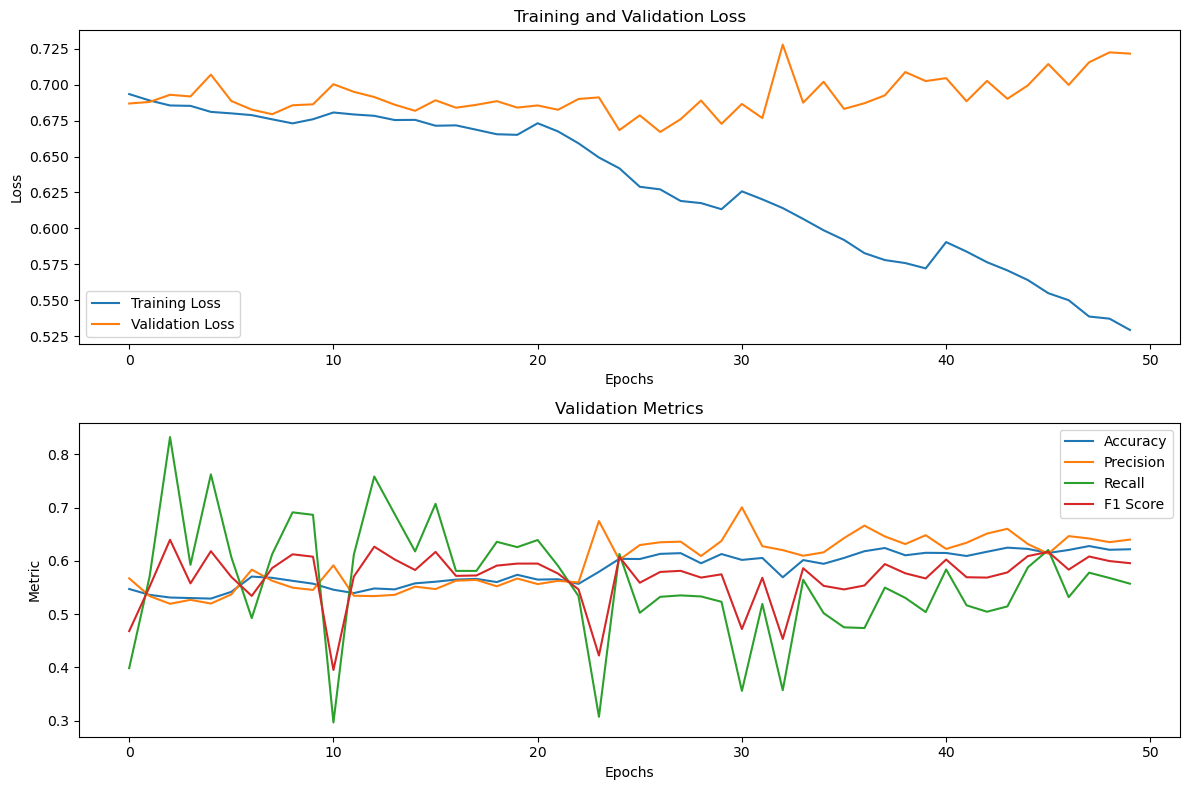

In [23]:
training_method(model, criterion, cnn_optimizer, text_optimizer, head_optimizer, cnn_scheduler, text_scheduler, head_scheduler, num_epochs=50, train_loader=train_dataloader, val_loader=val_dataloader)

In [605]:
  # # LOAD MODEL FROM PATH
# vocab_size = len(vocab)   # Total number of words in vocabulary
# embedding_dim = 100       # Dimension of word embeddings
# lstm_hidden_dim = 128     # Hidden state size for LSTM
# num_classes = 1           # Binary classification (matching or non-matching)
# 
# # Initialize the model
# model = ImageTextClassifier(vocab_size, embedding_dim, lstm_hidden_dim, num_classes)
# model_path = "vocab_size=3733+embedding_dim=128+num_filters=128+filter_sizes=[3, 4, 5, 6, 7, 8]+seq_len=53+cnn_text_drop_value=0.5+cnn_dropout_value=0.4+transformer_dropout_value=0.5+num_classes=1+eval_loss=0.6202353974606128.pt"
# model.load_state_dict(torch.load(model_path, weights_only=True))
# model.to(device)

In [606]:
ids = []
predictions = []

def make_submission(model, test_loader):
    model.eval()

    with torch.no_grad():
        for batch in tqdm(test_loader):
            images = batch['images'].to(device)
            captions = batch['captions'].to(device)
            id = batch['id']
            
            output = model(images, captions)
            preds = (torch.sigmoid(output) > 0.5).int()
            
            ids.extend(id)
            predictions.extend(preds.cpu().tolist())
    df = pd.DataFrame({'id': ids, 'label': predictions})
    df.to_csv('submission_cnn+LSTM.csv', index=False)

In [607]:
# make_submission(model, test_dataloader)

In [608]:
import gc
from itertools import product


def hyperparameter_tuning(vocab_size):

    # Create all combinations of hyperparameters
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]
    
    for params in tqdm(param_combinations):
        print(f"Testing configuration: {params}")
        
        try:
            # Update model configuration
            model_config = {
            "vocab_size" : vocab_size,
            "embedding_dim": params["embedding_dim"],       
            "cnn_dropout": params["cnn_dropout"], 
            "lstm_hidden_dim": params["lstm_hidden_dim"], 
            "lstm_dropout": params["lstm_dropout"],
            "head_dropout_value": params["head_dropout_value"]
            }
            
            # Initialize model
            model = ImageTextClassifier(**model_config)
            model.to(device)
            model.apply(initialize_weights)
            
            cnn_params = model.cnn.parameters()
            text_params = model.text_module.parameters()
            head_params = model.head.parameters()
            
            # Define criterion, optimizer, and scheduler
            criterion = nn.BCEWithLogitsLoss()
            cnn_optimizer = optim.AdamW(cnn_params, lr=params["lr_cnn"])
            text_optimizer = optim.AdamW(text_params, lr=params["lr_text"])
            head_optimizer = optim.AdamW(head_params, lr=params["lr_head"])
            
            cnn_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                cnn_optimizer, 
                T_0=10,  # Number of epochs before the first restart
                T_mult=2,  # Multiplicative factor for increasing restart period
                eta_min=params["lr_eta_min_cnn"]  # Minimum learning rate
            )
            
            text_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                text_optimizer,
                T_0=10,  # Number of epochs before the first restart
                T_mult=2,  # Multiplicative factor for increasing restart period
                eta_min=params["lr_eta_min_text"]  # Minimum learning rate
            )
            
            head_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                head_optimizer,
                T_0=10,  # Number of epochs before the first restart
                T_mult=2,  # Multiplicative factor for increasing restart period
                eta_min=params["lr_eta_min_head"]  # Minimum learning rate
            )

            
            # Train the model
            training_method(model, criterion, cnn_optimizer, text_optimizer, head_optimizer, cnn_scheduler, text_scheduler, head_scheduler, num_epochs=50, train_loader=train_dataloader, val_loader=val_dataloader, patience=5, delta = 0, loss_procentage_improvement=10, pred_thresh=0.5)
            print(f"Completed configuration: {params}")
        
        except RuntimeError as e:
            print(f"Error with configuration: {params}")
            print(f"Error message: {str(e)}")
        
        finally:
            # Reset GPU memory
            print("Resetting GPU memory...")
            torch.cuda.empty_cache()
            gc.collect()

In [609]:
import math

param_grid = {
    "embedding_dim": [64],
    "cnn_dropout": [0.25],
    "lstm_hidden_dim": [64],
    "transformer_dropout_value": [0.5],
    "lstm_dropout": [0.25],
    "head_dropout_value": [0.25],
    "lr_cnn": [1e-3, 5e-3],  
    "lr_text": [1e-4, 5e-4, 1e-3, 5e-3],  
    "lr_head": [1e-4, 1e-3],  
    "lr_eta_min_cnn": [1e-4],  
    "lr_eta_min_text": [1e-5], 
    "lr_eta_min_head": [1e-5],
}

total_combinations = math.prod(len(values) for values in param_grid.values())
print(f"Total combinations: {total_combinations}")

time_per_epoch = 23  # seconds
num_epochs = 50  # epochs per configuration
total_time_seconds = total_combinations * time_per_epoch * num_epochs

# Convert to hours
total_time_hours = total_time_seconds / 3600
print(f"Total time to hyper tune: {total_time_hours} hours")

Total combinations: 16
Total time to hyper tune: 5.111111111111111 hours


In [ ]:
hyperparameter_tuning(len(vocab))

  0%|          | 0/16 [00:00<?, ?it/s]

Testing configuration: {'embedding_dim': 64, 'cnn_dropout': 0.25, 'lstm_hidden_dim': 64, 'transformer_dropout_value': 0.5, 'lstm_dropout': 0.25, 'head_dropout_value': 0.25, 'lr_cnn': 0.001, 'lr_text': 0.0001, 'lr_head': 0.0001, 'lr_eta_min_cnn': 0.0001, 'lr_eta_min_text': 1e-05, 'lr_eta_min_head': 1e-05}
